In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,413 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,594 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://secu

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spam Detection ") \
    .getOrCreate()


print("Spark initialized:", spark.version)


Spark initialized: 3.5.1


In [3]:
df1 = spark.read.csv("/content/drive/MyDrive/finalyear_eng/spark/spam detection tp2/spam.csv", header=True, inferSchema=True)
df1 = df1.withColumnRenamed("v1", "label").withColumnRenamed("v2", "text")
df1.show(5)

+-----+--------------------+----+----+----+
|label|                text| _c2| _c3| _c4|
+-----+--------------------+----+----+----+
|  ham|Go until jurong p...|NULL|NULL|NULL|
|  ham|Ok lar... Joking ...|NULL|NULL|NULL|
| spam|Free entry in 2 a...|NULL|NULL|NULL|
|  ham|U dun say so earl...|NULL|NULL|NULL|
|  ham|Nah I don't think...|NULL|NULL|NULL|
+-----+--------------------+----+----+----+
only showing top 5 rows



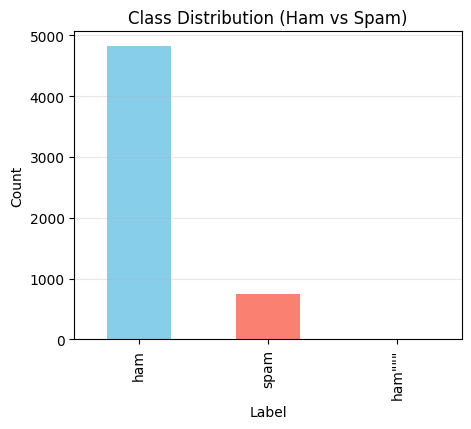

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = df1.select("label").toPandas()
label_counts = pdf["label"].value_counts()

plt.figure(figsize=(5,4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution (Ham vs Spam)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()


# **Data Preprocessing**

In [5]:
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when

# Handle null values in the "text" column
df1 = df1.withColumn("text", when(col("text").isNull(), "").otherwise(col("text")))


# Label encoding
label_indexer = StringIndexer(inputCol="label", outputCol="labelIndex")

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# Stop words removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# TF-IDF feature extraction
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build pipeline
preprocess_pipeline = Pipeline(stages=[label_indexer, tokenizer, remover, hashingTF, idf])

# Fit and transform
processed_df1 = preprocess_pipeline.fit(df1).transform(df1)
processed_df1.select("label", "filtered", "features").show(5)

+-----+--------------------+--------------------+
|label|            filtered|            features|
+-----+--------------------+--------------------+
|  ham|[go, jurong, poin...|(10000,[740,750,1...|
|  ham|[ok, lar..., joki...|(10000,[1727,2630...|
| spam|[free, entry, 2, ...|(10000,[587,1073,...|
|  ham|[u, dun, say, ear...|(10000,[594,3768,...|
|  ham|[nah, think, goes...|(10000,[2335,3163...|
+-----+--------------------+--------------------+
only showing top 5 rows



# **Split Data into Training and Test Sets**

In [6]:
train_df, test_df = processed_df1.randomSplit([0.8, 0.2], seed=42)
print(f"Training samples: {train_df.count()}, Test samples: {test_df.count()}")


Training samples: 4503, Test samples: 1071


# **Train Multiple Models**

In [7]:
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression

nb = NaiveBayes(featuresCol="features", labelCol="labelIndex")
rf = RandomForestClassifier(featuresCol="features", labelCol="labelIndex", numTrees=100)
lr = LogisticRegression(featuresCol="features", labelCol="labelIndex", maxIter=20)

nb_model = nb.fit(train_df)
rf_model = rf.fit(train_df)
lr_model = lr.fit(train_df)


# **Model Evaluation**

,Model,Accuracy,F1
0,Naive Bayes,0.859010,0.900107
1,Random Forest,0.861811,0.797845
2,Logistic Regression,0.957049,0.959165


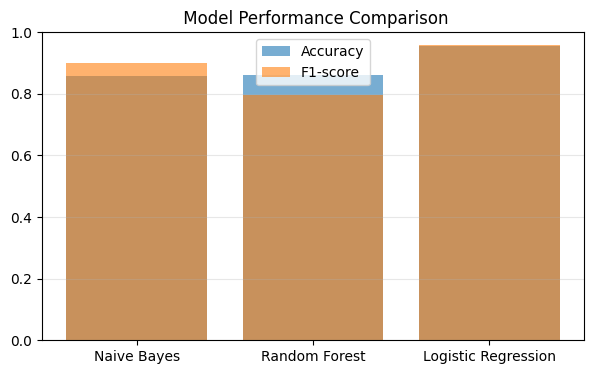

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(model, test_data, name):
    preds = model.transform(test_data)
    eval_acc = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
    eval_f1 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="f1")
    return name, eval_acc.evaluate(preds), eval_f1.evaluate(preds)

results = [
    evaluate_model(nb_model, test_df, "Naive Bayes"),
    evaluate_model(rf_model, test_df, "Random Forest"),
    evaluate_model(lr_model, test_df, "Logistic Regression")
]

# Convert to Pandas for visualization
perf_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1"])
display(perf_df)

# Plot comparison
plt.figure(figsize=(7,4))
plt.bar(perf_df["Model"], perf_df["Accuracy"], label="Accuracy", alpha=0.6)
plt.bar(perf_df["Model"], perf_df["F1"], label="F1-score", alpha=0.6)
plt.title(" Model Performance Comparison")
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


# **Explore Common Words**

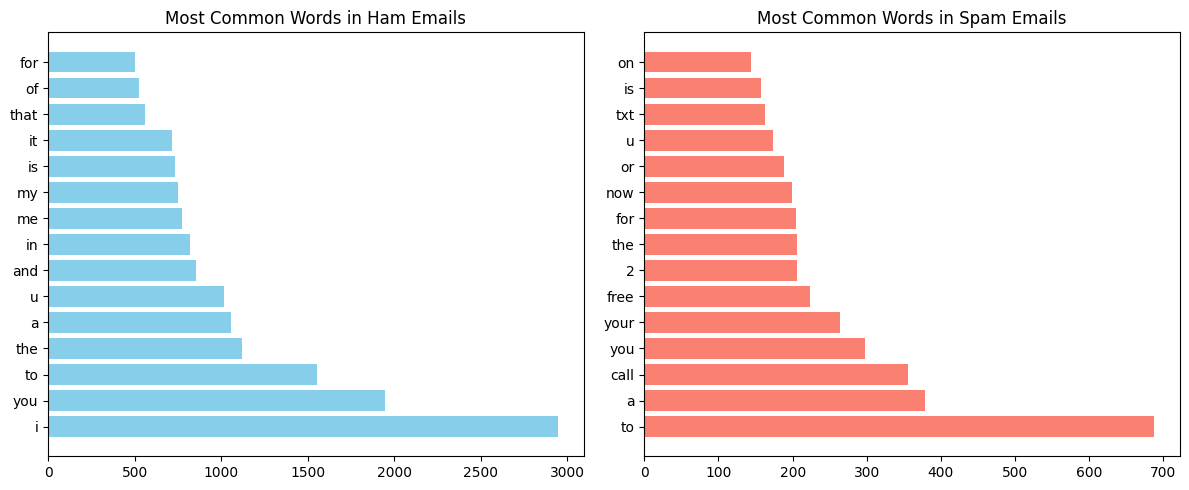

In [9]:
ham_texts = df1.filter(df1.label == "ham").select("text").toPandas()["text"]
spam_texts = df1.filter(df1.label == "spam").select("text").toPandas()["text"]

from collections import Counter
import re

def get_top_words(texts, n=15):
    words = re.findall(r'\b\w+\b', " ".join(texts).lower())
    return Counter(words).most_common(n)

ham_common = get_top_words(ham_texts)
spam_common = get_top_words(spam_texts)

ham_df = pd.DataFrame(ham_common, columns=["Word","Count"])
spam_df = pd.DataFrame(spam_common, columns=["Word","Count"])

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].barh(ham_df["Word"], ham_df["Count"], color="skyblue")
axes[0].set_title("Most Common Words in Ham Emails")
axes[1].barh(spam_df["Word"], spam_df["Count"], color="salmon")
axes[1].set_title("Most Common Words in Spam Emails")
plt.tight_layout()
plt.show()


# **Predict New Emails**

In [10]:
new_emails = [
    ("Congratulations! You have won $1000 cash prize! Click to claim.",),
    ("Hi John, are you free for coffee tomorrow?",)
]
new_df = spark.createDataFrame(new_emails, ["text"])
new_processed = preprocess_pipeline.fit(df1).transform(new_df)

best_model = lr_model
preds = best_model.transform(new_processed)
preds.select("text", "prediction").show(truncate=False)


+---------------------------------------------------------------+----------+
|text                                                           |prediction|
+---------------------------------------------------------------+----------+
|Congratulations! You have won $1000 cash prize! Click to claim.|1.0       |
|Hi John, are you free for coffee tomorrow?                     |0.0       |
+---------------------------------------------------------------+----------+



# **Deployment with Gradio**

In [11]:
import gradio as gr

def predict_email(text):
    sample_df = spark.createDataFrame([(text,)], ["text"])
    processed = preprocess_pipeline.fit(df1).transform(sample_df)
    result = best_model.transform(processed).select("prediction").collect()[0][0]
    return "🚨 Spam" if result == 1.0 else "✅ Not Spam"

iface = gr.Interface(
    fn=predict_email,
    inputs=gr.Textbox(label="Enter email text here"),
    outputs="text",
    title="📧 Spam Detection with PySpark",
    description="Enter an email message to check if it's spam or not."
)
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://36b69a7f4dabbb42a6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Dataset 2**

+----------------------------------+--------------------------------------------------------------------------------------+-----+
|AUTHOR                            |text                                                                                  |label|
+----------------------------------+--------------------------------------------------------------------------------------+-----+
|dharma pal                        |Nice song﻿                                                                            |0    |
|Tiza Arellano                     |I love song ﻿                                                                         |0    |
|Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿|I love song ﻿                                                                         |0    |
|Eric Gonzalez                     |860,000,000 lets make it first female to reach one billion!! Share it and replay it! ﻿|0    |
|Analena López                     |shakira is best for worldcup﻿                         

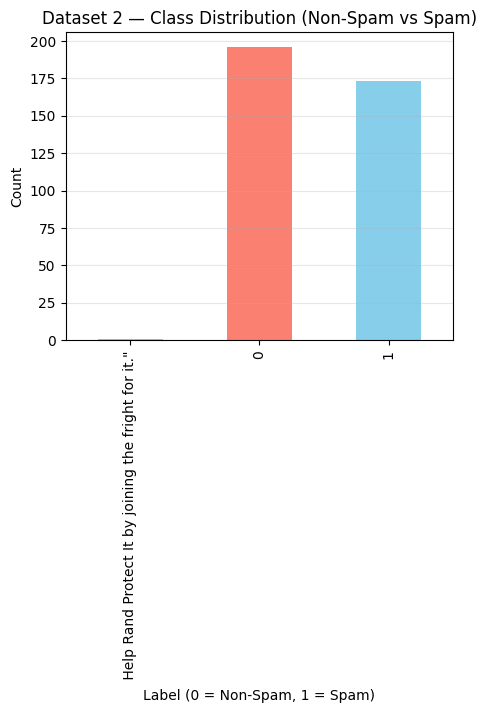

In [12]:
df2 = spark.read.csv("/content/drive/MyDrive/finalyear_eng/spark/spam detection tp2/spam2.csv", header=True, inferSchema=True)

# Rename for consistency
df2 = df2.withColumnRenamed("CONTENT", "text").withColumnRenamed("CLASS", "label")

# Show a few examples
df2.select("AUTHOR", "text", "label").show(5, truncate=False)

# Label distribution
pdf2 = df2.select("label").toPandas()
label_counts2 = pdf2["label"].value_counts().sort_index()

plt.figure(figsize=(5,4))
label_counts2.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Dataset 2 — Class Distribution (Non-Spam vs Spam)")
plt.xlabel("Label (0 = Non-Spam, 1 = Spam)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [13]:
# Pre-processing and Data Split
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

# Convert label to numeric (StringIndexer handles in case of string labels)
label_indexer2 = StringIndexer(inputCol="label", outputCol="labelIndex")
tokenizer2 = Tokenizer(inputCol="text", outputCol="words")
remover2 = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF2 = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf2 = IDF(inputCol="rawFeatures", outputCol="features")

pipeline2 = Pipeline(stages=[label_indexer2, tokenizer2, remover2, hashingTF2, idf2])
processed_df2 = pipeline2.fit(df2).transform(df2)

# Split into training/testing sets
train2, test2 = processed_df2.randomSplit([0.8, 0.2], seed=42)
print(f"Training samples: {train2.count()} | Test samples: {test2.count()}")

# Preview
processed_df2.select("label", "filtered").show(5, truncate=False)

Training samples: 315 | Test samples: 55
+-----+--------------------------------------------------------------------------------------+
|label|filtered                                                                              |
+-----+--------------------------------------------------------------------------------------+
|0    |[nice, song﻿]                                                                         |
|0    |[love, song, ﻿]                                                                       |
|0    |[love, song, ﻿]                                                                       |
|0    |[860,000,000, lets, make, first, female, reach, one, billion!!, share, replay, it!, ﻿]|
|0    |[shakira, best, worldcup﻿]                                                            |
+-----+--------------------------------------------------------------------------------------+
only showing top 5 rows



In [24]:
comment=test2.text
comment

Column<'text'>

In [26]:

test2.select("text","label").show(10, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

,Model,Accuracy,F1
0,Naive Bayes,0.872727,0.873162
1,Random Forest,0.800000,0.780952
2,Logistic Regression,0.909091,0.907741


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


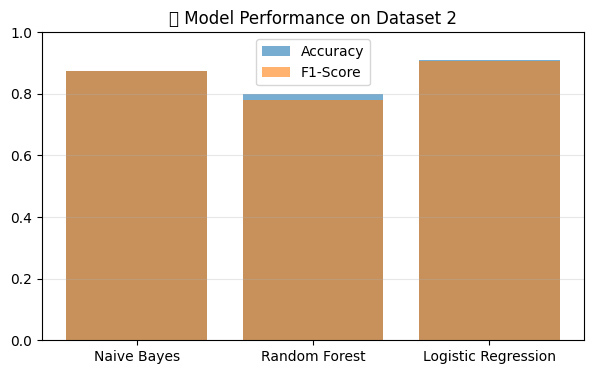

In [14]:
# Train, Evaluate, and Visualize Models on Dataset 2
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train models
nb2_model = NaiveBayes(featuresCol="features", labelCol="labelIndex").fit(train2)
rf2_model = RandomForestClassifier(featuresCol="features", labelCol="labelIndex", numTrees=100).fit(train2)
lr2_model = LogisticRegression(featuresCol="features", labelCol="labelIndex", maxIter=20).fit(train2)

# Evaluation helper
def evaluate_model(model, test_data, name):
    preds = model.transform(test_data)
    acc_eval = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
    f1_eval = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="f1")
    return name, acc_eval.evaluate(preds), f1_eval.evaluate(preds)

# Evaluate models
results2 = [
    evaluate_model(nb2_model, test2, "Naive Bayes"),
    evaluate_model(rf2_model, test2, "Random Forest"),
    evaluate_model(lr2_model, test2, "Logistic Regression")
]

# Show table + bar chart
perf_df2 = pd.DataFrame(results2, columns=["Model", "Accuracy", "F1"])
display(perf_df2)

plt.figure(figsize=(7,4))
plt.bar(perf_df2["Model"], perf_df2["Accuracy"], label="Accuracy", alpha=0.6)
plt.bar(perf_df2["Model"], perf_df2["F1"], label="F1-Score", alpha=0.6)
plt.title("📊 Model Performance on Dataset 2")
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [15]:
# Gradio Interface for Dataset 2 Spam Detection
import gradio as gr

# We'll use the Logistic Regression model as best
best_model2 = lr2_model

def predict_comment(text):
    # Convert the text to Spark DataFrame
    new_df = spark.createDataFrame([(text,)], ["text"])
    # Apply the preprocessing pipeline (reusing pipeline2)
    processed = pipeline2.fit(df2).transform(new_df)
    # Predict using the trained model
    prediction = best_model2.transform(processed).select("prediction").collect()[0][0]
    return "🚨 Spam" if prediction == 1.0 else "✅ Not Spam"

# Build the Gradio interface
iface2 = gr.Interface(
    fn=predict_comment,
    inputs=gr.Textbox(label="Enter comment text"),
    outputs=gr.Textbox(label="Prediction result"),
    title="💬 YouTube Comment Spam Detector (Dataset 2)",
    description="Enter a YouTube comment and check if it’s spam or not. (Model trained with PySpark MLlib)",
    theme="default"
)

iface2.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6d1e91a13be0d62715.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [28]:
# Gradio Interface for Dataset 2
import gradio as gr
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- Evaluate once to get each model's accuracy (reuse test2) ---
evaluator_acc = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")

acc_nb = evaluator_acc.evaluate(nb2_model.transform(test2))
acc_rf = evaluator_acc.evaluate(rf2_model.transform(test2))
acc_lr = evaluator_acc.evaluate(lr2_model.transform(test2))

# Store accuracies in a dictionary for easy access
model_accuracies = {
    "Naive Bayes": round(acc_nb, 3),
    "Random Forest": round(acc_rf, 3),
    "Logistic Regression": round(acc_lr, 3)
}

# --- Function to predict and show results ---
def predict_comment_all(text):
    # Create a Spark DataFrame from input
    new_df = spark.createDataFrame([(text,)], ["text"])

    # Apply preprocessing pipeline
    processed = pipeline2.fit(df2).transform(new_df)

    # Predictions
    pred_nb = nb2_model.transform(processed).select("prediction").collect()[0][0]
    pred_rf = rf2_model.transform(processed).select("prediction").collect()[0][0]
    pred_lr = lr2_model.transform(processed).select("prediction").collect()[0][0]

    # Convert predictions to readable labels
    def label(pred):
        return "🚨 Spam" if pred == 1.0 else "✅ Not Spam"

    # Combine results with accuracy
    results = {
        "Naive Bayes": {
            "Prediction": label(pred_nb),
            "Model Accuracy": model_accuracies["Naive Bayes"]
        },
        "Random Forest": {
            "Prediction": label(pred_rf),
            "Model Accuracy": model_accuracies["Random Forest"]
        },
        "Logistic Regression": {
            "Prediction": label(pred_lr),
            "Model Accuracy": model_accuracies["Logistic Regression"]
        }
    }

    return results

# --- Gradio Interface ---
iface2 = gr.Interface(
    fn=predict_comment_all,
    inputs=gr.Textbox(label="Enter comment text"),
    outputs=gr.JSON(label="Predictions + Accuracy (All Models)"),
    title="💬 YouTube Comment Spam Detector",
    description=(
        "Enter a YouTube comment below — the app predicts whether it's spam or not using "
        "three ML models (Naive Bayes, Random Forest, Logistic Regression) built with PySpark MLlib."
    ),
    theme="default"
)

iface2.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://82cae8208d070fe574.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
